### Data preprocessing and reading files

In [1]:
# Import section

import pandas as pd
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
users_data = pd.read_csv('/Users/davidgrigorev/Documents/portfolio_projects/ab_testing/data/ab_users_data.csv')
orders = pd.read_csv('/Users/davidgrigorev/Documents/portfolio_projects/ab_testing/data/ab_orders.csv')
products = pd.read_csv('/Users/davidgrigorev/Documents/portfolio_projects/ab_testing/data/ab_products.csv')

In [3]:
# Converting data containing date and time into a convenient format.

users_data['date'] = pd.to_datetime(users_data['date'])
users_data['time'] = pd.to_datetime(users_data['time'])
orders['creation_time'] = pd.to_datetime(orders['creation_time'])

### Preliminary data study

In [4]:
# The time frame in which the data was collected.

print(users_data.date.min())
print(users_data.date.max())

2022-08-26 00:00:00
2022-09-08 00:00:00


In [5]:
# No NA values

print(users_data.isna().sum(), end='\n\n')
print(orders.isna().sum(),end='\n\n')
print(products.isna().sum())

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

order_id         0
creation_time    0
product_ids      0
dtype: int64

product_id    0
name          0
price         0
dtype: int64


In [6]:
# Checking data types.

print(users_data.dtypes, end='\n\n')
print(orders.dtypes, end='\n\n')
print(products.dtypes)

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

product_id      int64
name           object
price         float64
dtype: object


### Selecting metrics for testing.
The following metrics will be used for analysis:

**1) Number of order cancellations**  
**2) Average number of orders per user**  
**3) Average order value**  
**4) Average order size**

## Test 1. Number of order cancellations
* **Null hypothesis:** The number of order cancellations in the control and experimental groups is statistically significant **not different**.
* **Alternative hypothesis:** The number of order cancellations in the control and experimental groups is statistically significantly **different**.

* To solve this problem, first, let's create a contingency table. Where we can look at the number of order cancellations in each group.
  
* Further, to carry out the analysis we will use the **Chi square** method, since we are dealing with a categorical attribute that takes into account two meanings: whether cancellation occurred or not. We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [7]:
# creating contingency table

contingency_table = pd.crosstab(users_data['group'], users_data['action'])
print(contingency_table)

action  cancel_order  create_order
group                             
0                 82          1609
1                132          2514


In [8]:
# Conducting a chi-square test

chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"The value of the chi-square statistic: {chi2}")
print(f"p-value: {p_val}")

The value of the chi-square statistic: 0.018211165651942023
p-value: 0.8926523935841298


#### Test results
After the test, the value **p-value = 0.89** Which significantly exceeds the established significance threshold of 0.05. As a result, we can conclude that this test did not reveal statistically significant differences. This means that we should **accept the null hypothesis**.

## Test 2. Average number of orders per user

To carry out the analysis, we will pre-prepare our data.
As a result of a preliminary study of the data, it was found that in the *users_data* table, canceled orders (that is, orders with the status *cancel_order* in the *action* column) will not have a decisive meaning in further research. Since we have already conducted research on the number of order cancellations and have not identified statistically significant differences in the group.

For ease of analysis, we will create a table *users_data_new* which will not contain data about canceled orders, but will contain data exclusively with created orders (Since in any case, both canceled and created orders for each order have the same *user_id* and *order_id* and in this sense, we will not lose a single order)

In [9]:
# implementation by removing duplicates using the 'order_id' column

users_data_new = users_data.drop_duplicates(subset=['order_id'])
users_data_new.action.unique()   # Only orders with the status 'create_order' remain.

array(['create_order'], dtype=object)

* Also, for further analysis, we will create a new dataframe, which will be a synthesis of *users_data_new* and *orders*. In further studies we will mainly use this df.


* Next, we will create data with the number of orders for each user in groups. Data for the control group will be contained in the variable *orders_per_user_control*, and for the experimental group in the variable *orders_per_user_exp*

In [10]:
# We create a new df using merge. We also select the necessary columns
users_orders = pd.merge(users_data_new[['user_id', 'order_id', 'date', 'group' ]], orders, on='order_id', how='left')

# We create variables with data on the number of orders for each user.
orders_per_user_control = users_orders.query('group == 0').groupby('user_id').order_id.count()
orders_per_user_exp = users_orders.query('group == 1').groupby('user_id').order_id.count()

# Corresponding averages
orders_per_user_control_avg = round(orders_per_user_control.mean(), 2)
orders_per_user_exp_avg = round(orders_per_user_exp.mean(),2)

print(f'Average number of orders per user in the control group = {orders_per_user_control_avg}', \
      f'Average number of orders per user in the experimental group = {orders_per_user_exp_avg}', \
      sep='\n')

Average number of orders per user in the control group = 3.12
Average number of orders per user in the experimental group = 5.01


/Users/davidgrigorev/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/davidgrigorev/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(4.944444444444445, 0.5, 'Amount of users')

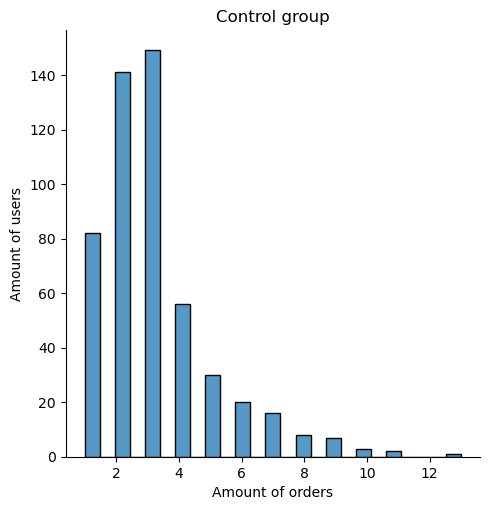

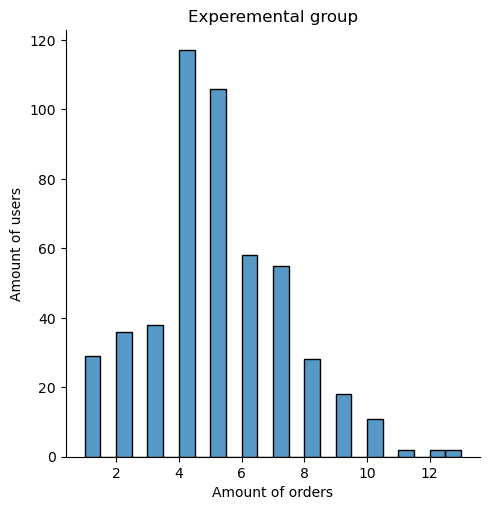

In [11]:
# Visualize the distributions in each group
sns.displot(orders_per_user_control)
plt.title('Control group')
plt.xlabel('Amount of orders')
plt.ylabel('Amount of users')

sns.displot(orders_per_user_exp)
plt.title('Experemental group')
plt.xlabel('Amount of orders')
plt.ylabel('Amount of users')

When visualizing the resulting distributions, it is quite difficult to assess the normality of these distributions.
Taking this into account, let's check the data for normality. And to visualize normality we use qq plot.

* **Null hypothesis for distributions:** Distributions are **normal**.
* **Alternative hypothesis for distributions:** Distributions are **not normal**.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [12]:
# Carrying out normality tests:
print(ss.normaltest(orders_per_user_control))   # control group
print(ss.normaltest(orders_per_user_exp))   # exp group

NormaltestResult(statistic=168.68174543124155, pvalue=2.350847085591091e-37)
NormaltestResult(statistic=21.897130007276786, pvalue=1.758322907569066e-05)


Text(0.5, 1.0, 'Q-Q plot Experimental group')

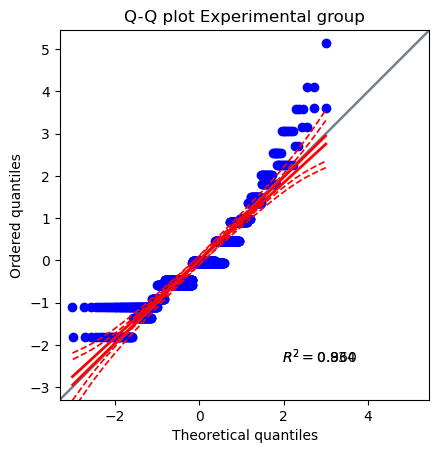

In [13]:
# Visualization of normality of distributions
pg.qqplot(orders_per_user_control)
plt.title('Q-Q plot Control group')

pg.qqplot(orders_per_user_exp)
plt.title('Q-Q plot Experimental group')

Having carried out appropriate tests for normality, we obtained a p-value significantly below the established threshold for both the control and experimental groups.

As a result, we have reason to reject the null hypothesis of normality in both groups. And also accept the alternative hypothesis that the distributions in our groups are not normal. The results are also confirmed by qq plot graphs

####  Carrying out tests.
In our groups, the distribution is not normal, however, our samples have a sufficient number of observations. On sufficiently large samples, provided that the variance is homogeneous and the data are independent, it is possible to use the **t-test**, even in the case of a non-normal distribution, this is exactly our case. Therefore, I see it advisable to use t-test.


* **Null hypothesis:** The average number of orders made by one user in the control and experimental groups is statistically significant **not different**.
* **Alternative hypothesis:** The average number of orders made by one user in the control and experimental groups is statistically significantly **different**.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**


In [14]:
# Conducting T-test
print(ss.ttest_ind(orders_per_user_control, orders_per_user_exp))

TtestResult(statistic=-14.51086812343365, pvalue=1.6974865514796019e-43, df=1015.0)


#### Test results
Our test showed that the p-value is significantly below the established threshold. As a result, we have every reason to reject the null hypothesis and accept the alternative.


We can say that the averages are indeed statistically significantly different, and the increased number of orders in the experimental group may indicate positive dynamics in the quality of our service.

### Test 3. Average order value

To carry out the analysis, let’s prepare the data a little. First, let's convert the data in the *product_ids* column into a list format, this will make it easier to work with.

In [15]:
# We wrap the data in the form of lists in the product_ids column

users_orders.product_ids = users_orders.product_ids.apply(lambda x: x.replace('{', ''))
users_orders.product_ids = users_orders.product_ids.apply(lambda x: x.replace('}', ''))
users_orders.product_ids = users_orders.product_ids.apply(lambda x: x.split(','))
# users_orders['size'] = users_orders.product_ids.apply(lambda x: len(x))
users_orders

,user_id,order_id,date,group,creation_time,product_ids
0,964,1255,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,2022-08-26,0,2022-08-26 00:02:56,"[74, 6]"
4,967,1259,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"
...,...,...,...,...,...,...
4118,990,59422,2022-09-08,1,2022-09-08 23:13:03,"[84, 8, 24]"
4119,1418,59439,2022-09-08,1,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]"
4120,1605,59464,2022-09-08,0,2022-09-08 23:22:27,"[60, 41, 46]"
4121,1461,59487,2022-09-08,0,2022-09-08 23:29:06,"[9, 62, 77]"


Next, to calculate the average order cost, we need to get the price data from the *products* table and assign a total price to each order based on the prices of the products contained in the order.

To implement this, apply the explode() function to the column with *product_ids* in the *users_orders* table. To all the resulting data with product_id, we apply a function that will convert the number data into an integer form.

We will connect the resulting table with the *products* table and, accordingly, we will be able to get the price for each individual product. After that, we will group the data by *order_id* and *group*, and also apply the sum() aggregating function to the *price* column. Let's call the resulting df *order_price*.

From the resulting dataframe, we extract separately the data for the control and experimental groups and assign the variables *order_value_control* for the control group and *order_value_exp* for the experimental group

In [16]:
# Using explode and wrapping data with product_ids in integer form.
expl = users_orders.explode('product_ids')
expl['product_ids'] = expl['product_ids'].apply(lambda x: int(x))

# We connect the df obtained after explode with the df products. On this basis, we create a df with order_price containing the cost of each order
us_or_pr = expl.merge(products, how='left', left_on='product_ids', right_on='product_id')
order_price = us_or_pr.groupby(['order_id', 'group'], as_index=False)['price'].sum()

# Data with cost of orders by groups
order_value_control = order_price.query('group == 0')['price']
order_value_exp = order_price.query('group == 1')['price']

# Corresponding means for the control and experimental groups.
order_value_control_avg = round(order_value_control.mean(), 1)
order_value_exp_avg = round(order_value_exp.mean(), 1)

print(f'Average order cost for control group = {order_value_control_avg}', \
     f'Average order cost for experimental group = {order_value_exp_avg}', \
     sep='\n')

Average order cost for control group = 381.3
Average order cost for experimental group = 369.6


As you can see, in our study group the average order value is lower than in the control group. Next, we will examine whether these differences are statistically significant.


We will also visualize the distribution using boxplot

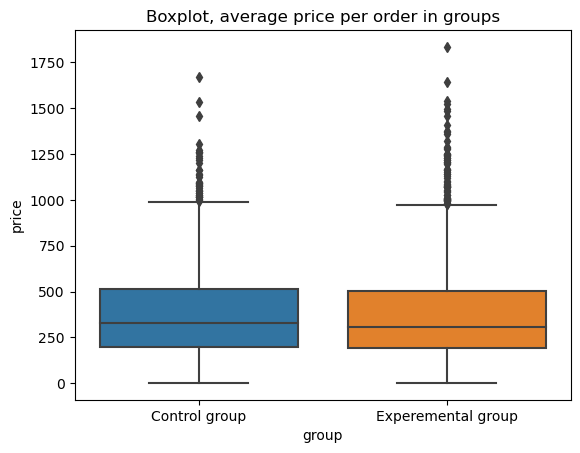

In [17]:
box = sns.boxplot(data=order_price, x='group', y='price')
box.set_xticklabels(['Control group', 'Experemental group'])
plt.title('Boxplot, average price per order in groups')
plt.show()

Next, let's check our distributions for normality. And to visualize normality we use qq plot.

* **Null hypothesis for distributions:** Distributions are **normal**.
* **Alternative hypothesis for distributions:** Distributions are **not normal**.
* Let's determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [18]:
# Checking distributions for normality
print(ss.normaltest(order_value_control))
print(ss.normaltest(order_value_exp))

NormaltestResult(statistic=288.6208180681972, pvalue=2.122196897492167e-63)
NormaltestResult(statistic=597.6831916887269, pvalue=1.6396228483368307e-130)


Text(0.5, 1.0, 'Q-Q plot cost of orders in the experimental group')

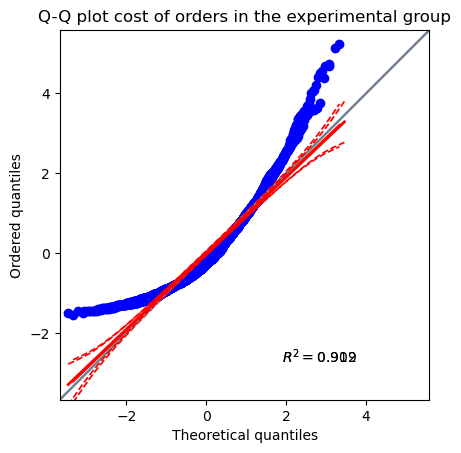

In [19]:
# Visualization of the normality of distribution in the control and experimental groups
pg.qqplot(order_value_control)
plt.title('Q-Q plot cost of orders in the control group')

pg.qqplot(order_value_exp)
plt.title('Q-Q plot cost of orders in the experimental group')

Visualization of the data, as well as the resulting p-value, indicate that we have statistically significant differences in both groups, which means that we cannot accept the null hypothesis of normal distribution, and are forced to admit that the data is not normally distributed.

#### Carrying out tests.
In our groups, the distribution is not normal, although the sample size is still large enough to apply the t-test in this case, we will use its non-parametric counterpart, namely the Mann-Whitney U test. It should be kept in mind that the U statistic counts the total number of cases in which the elements of the second sample are superior to the elements of the first sample.

* **Null hypothesis:** The median average order value of Group A is equal to the median average order value of Group B. 
* **Alternative hypothesis:** The median average order value of Group A is not equal to the median average order value of Group B.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [20]:
# Carrying out the Mann-Whitney U test
print(ss.mannwhitneyu(order_value_control, order_value_exp)) 

MannwhitneyuResult(statistic=2089849.5, pvalue=0.07091794237690839)


#### Test results
Our test showed that the p-value is significantly higher than the established threshold of 0.05. As a result, we can conclude that our test did not find statistically significant differences in the average cost of orders between the control and experimental groups.


We can say that our test could not reveal that the new recommendation system somehow affects the average order value.

## Test 4. Average order size


Here too, you will need to transform the data a little. First, in the *users_orders* table we will create a column that will contain order size values.

In [21]:
users_orders['size'] = users_orders.product_ids.apply(lambda x: len(x))

Creating a new df *orders_size* which will contain the values ​​of order id, group, as well as the corresponding order sizes.

Let's isolate the data for each group and place it in the variables *orders_size_control* for the control group and *orders_size_exp* for the experimental group. We will also create variables with corresponding means for each group.

In [22]:
# Create a df with the necessary data
orders_size = users_orders[['order_id', 'group', 'size']]

# Separate data for two groups
orders_size_control = orders_size.query('group == 0')
orders_size_exp = orders_size.query('group == 1')

# Corresponding average values
orders_size_control_avg = round(orders_size_control['size'].mean(), 4)
orders_size_exp_avg = round(orders_size_exp['size'].mean(), 4)

print(f'Average order size for control group = {orders_size_control_avg}', \
      f'Average order size for experimental group = {orders_size_exp_avg}', \
     sep='\n')

Average order size for control group = 3.3499
Average order size for experimental group = 3.3556


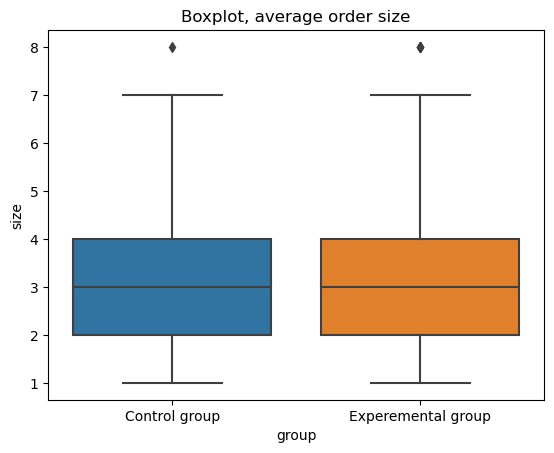

In [23]:
box_2 = sns.boxplot(data=orders_size, x='group', y='size')
box_2.set_xticklabels(['Control group', 'Experemental group'])
plt.title('Boxplot, average order size')
plt.show()

As you can see, the average order sizes in our groups do not differ very much. However, even small group differences may be statistically significant, so appropriate tests should be performed regardless of small group differences.


As before, first of all, let's check our data for normality. We also visualize normality using qq-plot.

* **Null hypothesis for distributions:** Distributions are **normal**.
* **Alternative hypothesis for distributions:** Distributions are **not normal**.
* Let's determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [24]:
# Check data for normality
print(ss.normaltest(orders_size_control['size'])) 
print(ss.normaltest(orders_size_exp['size'])) 

NormaltestResult(statistic=37.487068075385594, pvalue=7.240800736554414e-09)
NormaltestResult(statistic=46.456176112445156, pvalue=8.169011962301803e-11)


Text(0.5, 1.0, 'Q-Q plot size of orders in the experimental group')

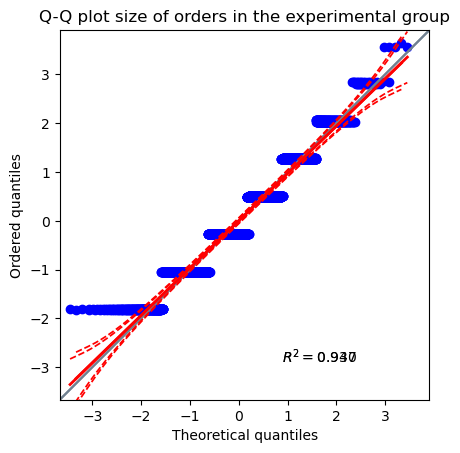

In [25]:
# Visualizing data normality
pg.qqplot(orders_size_control['size'])
plt.title('Q-Q plot size of orders in the control group')

pg.qqplot(orders_size_exp['size'])
plt.title('Q-Q plot size of orders in the experimental group')

Having carried out appropriate tests for normality, we obtained a p-value significantly below the established threshold for both the control and experimental groups.

As a result, we have reason to reject the null hypothesis of normality in both groups. And also accept the alternative hypothesis that the distributions in our groups are not normal. The results are also confirmed by qq plot graphs

####  Carrying out tests.
In our groups, the distribution is not normal, however, our samples have a sufficient number of observations. On sufficiently large samples, provided that the variance is homogeneous and the data are independent, it is possible to use the **t-test**, even in the case of a non-normal distribution, this is exactly our case. Therefore, I see it advisable to use t-test.



* **Null hypothesis:** The average order size in the control and experimental groups is statistically **not significantly different**.
* **Alternative hypothesis:** The average order size in the control and experimental groups is statistically significantly **different**.
* We will also determine the threshold at which differences in our data will be statistically significant. Let's set **a = 0.05**

In [26]:
# Application of Student's test
print(ss.ttest_ind(orders_size_control['size'], orders_size_exp['size']))

TtestResult(statistic=-0.1380397717649213, pvalue=0.8902157292521864, df=4121.0)


#### Test results
the test showed that the p-value is above the established threshold of 0.05. As a result, we can conclude that our test did not find statistically significant differences in the average size of orders between the control and experimental groups.

We can say that the new recommendation system does not affect the number of products that the average user orders per order.

### Research Conclusions and Analytical Summary.
As part of the research, a number of metrics were measured, and a series of statistical tests were conducted:
1) The number of canceled orders (Chi-square)
2) The average number of orders per user (Student's t-test)
3) The average cost of an order (Mann-Whitney U test)
4) The average order size (Student's t-test)

**The number of canceled orders (Chi-square)**
* This metric reflects the quality of the service provided. In my opinion, it is one of the key metrics. Undoubtedly, there can be many reasons for an order cancellation. And one of these reasons could be that our recommendations did not match the user's requests, leaving them unsatisfied with the order made.

* The research did not reveal any statistically significant differences in the group. Consequently, we cannot claim that the introduction of a new recommendation system has in any way affected such a metric as the number of order cancellations.

**The average number of orders per user (Student's t-test)**
* This metric reflects how often users started making purchases. I think this metric is the most important of those considered, as it reflects both the quality of the service provided and potential profits for the business.

* The test showed that there are statistically significant differences between the groups for this metric, and we can assert that the introduction of a new recommendation system affects how many orders a user places. Undoubtedly, the analysis of this metric argues in favor of expanding the new system to the entire audience.

**The average cost of an order (Mann-Whitney U test)**
* This metric essentially reflects the average customer bill. This indicator is primarily important for the business, as an increase in this indicator promises higher profits.

* Nevertheless, the analysis did not reveal any statistically significant differences. This indicates that the new recommendation system does not affect the average bill of an order.

**The average order size (Student's t-test)**
* This metric reflects the volume of orders. This indicator is also important, both as a measure of service quality and as a measure of profitability.

* However, the analysis did not reveal any statistically significant differences between the groups. It can be said that we were unable to determine how the new system affects the number of goods a user wants to purchase in a single order.

## Conclusion
The new recommendation system significantly influenced users' desire to place orders more frequently, which is a positive sign. The data for the other metrics could have changed, and sometimes even for the worse, but no statistically significant differences were found for such data in the groups. Accordingly, we cannot say that the new recommendation system has negatively affected the selected metrics.

It can be concluded that the decision to expand the new recommendation system to all users will at least not harm business indicators and at most improve some of them. With this in mind, **I would recommend expanding the recommendation system to all users.**